# **EE488 Machine Learning basics and practice**
## **Project 1**

## Objective
* part 1. Data Preparation
* part 2. Logistic Regression
* part 3. Hyperparameter Optimization
* part 4. PCA

## **Part1** Data Preparation
* This part is for downloading the dataset to be used in this project. 
* All the related codes are basically provided below.

### Step1. Download and decompress the MNIST dataset (4, 9 classes)

In [1]:
#Setting
import numpy as np
import os 
import pickle
import matplotlib.pyplot as plt

from urllib import request
from __future__ import division, print_function
from tqdm import tqdm

In [2]:
# {4, 9} class mnist dataset download and decompress
!pip install gdown
!gdown --id 1n70aILNV1U8I2VJlYekKuhBGbrNtCUNb
!tar -xvf mnist_49.tar
!rm -f mnist_49.tar

# Dataset Load
X_train = np.load('mnist_49/X_train.npy')
X_test = np.load('mnist_49/X_test.npy')
Y_train = np.load('mnist_49/Y_train.npy')
Y_test = np.load('mnist_49/Y_test.npy')

Downloading...
From: https://drive.google.com/uc?id=1n70aILNV1U8I2VJlYekKuhBGbrNtCUNb
To: /content/mnist_49.tar
10.9MB [00:00, 172MB/s]
mnist_49/
mnist_49/X_train.npy
mnist_49/X_test.npy
mnist_49/Y_test.npy
mnist_49/Y_train.npy
mnist_49/MNIST Copyright.txt


In [3]:
# Reshape the training and test examples
# Data from Part 1 - Step 1
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

print('X_train_flatten shape: ' + str(X_train_flatten.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('X_test_flatten shape: ' + str(X_test_flatten.shape))
print('Y_test shape: ' + str(Y_test.shape))

X_train_std = X_train_flatten / 255.
X_test_std = X_test_flatten / 255.

X_train_flatten shape: (11791, 784)
Y_train shape: (11791,)
X_test_flatten shape: (1991, 784)
Y_test shape: (1991,)


### Step2. Download and define a function for preparing the CIFAR10 dataset
If you put the classes you want to use in the form of a list (ex, [0, 1], [3, 5, 8], etc.) as an argument to the *'cifar10_subset'* function, then, this function returns training data/label and test data/label of classes.

In [4]:
#Download CIFAR10 Dataset
request.urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', 'cifar-10-python.tar.gz')
!tar -xzf cifar-10-python.tar.gz

In [5]:
for i in range(1,6):
    filename='data_batch_%d'%i
    with open('cifar-10-batches-py/'+filename, 'rb') as fo:
        dict_data = pickle.load(fo, encoding='bytes')
  
    images_batch = dict_data[b'data']
    labels_batch = dict_data[b'labels']
    if i==1:
        train_images = images_batch
        train_labels = labels_batch
    else:
        train_images = np.concatenate((train_images, images_batch), axis=0)
        train_labels.extend(labels_batch)
 
with open('cifar-10-batches-py/test_batch', 'rb') as fo:
    dict_data = pickle.load(fo, encoding='bytes')
  
test_images = dict_data[b'data']
test_labels = dict_data[b'labels']

In [6]:
train_indexes = sorted(range(len(train_labels)), key=lambda k: train_labels[k])
test_indexes = sorted(range(len(test_labels)), key=lambda k: test_labels[k])

In [7]:
def cifar10_subset(class_ind=[0,1]):
    assert (len(class_ind) >=2 and len(class_ind) <=10)
    assert (min(class_ind) >=0 and max(class_ind) <=9)
    train_images_cl = []
    train_labels_cl = []
    test_images_cl = []
    test_labels_cl = []
    for i in class_ind:
        train_inds = train_indexes[i*5000:(i+1)*5000]
        test_inds = test_indexes[i*1000:(i+1)*1000]
        train_images_tmp = train_images[train_inds,:]
        train_labels_tmp = np.array(train_labels)[train_inds]
        test_images_tmp = test_images[test_inds,:]
        test_labels_tmp = np.array(test_labels)[test_inds]

        train_images_cl.append(train_images_tmp)
        train_labels_cl.append(train_labels_tmp)
        test_images_cl.append(test_images_tmp)
        test_labels_cl.append(test_labels_tmp)
  
    return np.array(train_images_cl), np.array(train_labels_cl), np.array(test_images_cl), np.array(test_labels_cl)

## **Part2** Logistic Regression
* Understand and Implement Logistic Regression using numpy library.
* Apply your own classifier implemented by numpy to MNIST and CIFAR10 dataset.

### Step1. Implement Logistic Regression using Numpy

## **TODO** : Fill in the blank with the code by referring to the following formulas below for all the **steps 1-1 ~ 1-6.** You should write your own **description of your source code** in the report.

#### step 1-1. Implement Sigmoid Function

**Sigmoid:** $f(z) = \dfrac{1}{1+e^{-z}}$ where $z=w^T x$

In [8]:
def sigmoid(z):
    ######################## Blank ########################
    exp = np.exp(-z)
    sig = 1./(1.+exp)
    #######################################################
    return sig

In [9]:
# Print out the result of sigmoid function 

print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(4.5) = " + str(sigmoid(4.5)))
print ("sigmoid(-6) = " + str(sigmoid(-6)))

sigmoid(0) = 0.5
sigmoid(4.5) = 0.9890130573694068
sigmoid(-6) = 0.0024726231566347743


#### step 1-2. Implement forward propagation

__x__: Input data of size (sample_size, feature_size)

__y__: target (labels)

__w__: model weights

__predict__: prediction for each data point $x_i$; $h(w^Tx_i)=\dfrac{1}{1+e^{-w^T x_i}}$ 

__loss__: $J(w)=\frac{1}{n}\sum_{i=1}^n[-y_i\text{log}\{h(w^Tx_i)\} - (1-y_i)\text{log}\{1-h(w^Tx_i)\}]$

where $n$ is number of samples and $y$ is target.

**NOTE**: If you use ```np.log``` method, it is recommended to use as follows,

```python
np.log(x) -> np.log(x + eps)
```
where ```eps``` is small positive number used to avoid taking of almost zero value.

In [10]:
def forward(x, y, w, eps=1e-8):
    ######################## Blank ########################
    n = x.shape[0]
    linear = np.matmul(w.T, x.T)
    predict = sigmoid(np.array(linear))
    loss = -1/n * (np.matmul(y, np.log(predict+eps)) + np.matmul((1-y), np.log(1-predict+eps)))
    #print('predict shape' + str(predict.shape))
    #print('loss shape' + str(loss.shape))
    #######################################################
    return predict, loss

#### step 1-3. Implement backward propagation

__Hint:__ Refer to the following derivation.

$$
\begin{aligned}
\frac{\partial J(\boldsymbol{w})}{\partial \boldsymbol{w}} &=-\frac{1}{n} \sum_{i=1}^{n}\left[y_{i}\left(1-h\left(\boldsymbol{w}^{T} \boldsymbol{x}_{i}\right)\right)-\left(1-y_{i}\right) h\left(\boldsymbol{w}^{T} \boldsymbol{x}_{i}\right)\right] \boldsymbol{x}_{i} \\
&=\frac{1}{n} \sum_{i=1}^{n}\left[h\left(\boldsymbol{w}^{T} \boldsymbol{x}_{i}\right)-y_{i}\right] \boldsymbol{x}_{i}\\
&= \frac{1}{n} (\hat{Y}-Y)X
\end{aligned}
$$

__grad_w__: Gradient of weights

In [11]:
def backward(x, y, predict):
    ######################## Blank ########################
    n = x.shape[0] 
    grad_w = 1./n * (np.matmul((predict - y).T, x))
    #print('grad_w shape' + str(grad_w.shape))
    #######################################################
    return grad_w

#### step 1-4. Add bias unit

To implement the bias unit, insert ones column vertor into dataset $x$; Define $\bar{x}$ and $\bar{w}$ as follows:

$$
\bar{x}:=\left[\begin{array}{cc}
x_{1}^{T} & 1 \\
x_{2}^{T} & 1 \\
\vdots & \\
x_{n}^{T} & 1
\end{array}\right] \in \mathbf{R}^{n \times(d+1)}, \bar{w}:=\left[\begin{array}{c}
w \\
b
\end{array}\right] \in \mathbf{R}^{d+1}
$$

Argument __b__ of ```bias_unit``` function below refers to the bias term.

__x_bar__: $\bar{x}$

__w_bar__: $\bar{w}$

In [12]:
def bias_unit(x, w, b):
    ######################## Blank ########################
    n = x.shape[0]
    a = np.array([[1]*n])
    x_bar = np.concatenate((x, a.T), axis=1)
    w_bar = np.concatenate((w, np.array([[b]])), axis=0)
    #######################################################
    return x_bar, w_bar

#### step 1-5. Model initialization

Initialize the model(__w__ and __b__) with arbitrary(e.g. Guassian distribution) values.

* Initialize __w__ with gaussian distribution (use np.random.normal)
* Initialize __b__ with zero

In [13]:
def initialize_params(X_train, verbose=False):
    
    ######################## Blank ########################
    w = np.random.normal(size=(X_train.shape[1] , 1))
    b = 0
    #######################################################
    
    X_train_bar, w_bar = bias_unit(X_train, w, b) # add bias unit 
    if verbose:
        print('Before adding the bias unit')
        print('shape of X_train:, ', X_train.shape)
        print('w: ', w.__repr__())
        print('b: ', b.__repr__(), end='\n\n')
        print('After adding the bias unit')
        print('shape of X_train_bar:, ', X_train_bar.shape)
        print('w_bar: ', w_bar.__repr__())
    
    return X_train_bar, w_bar

#### step 1-6. Implement ```accuracy``` function  for computing the accuracy

Implement a function that return accuracy when ```predict``` $h(w^Tx_i)=\frac{1}
{1+e^{-w^T x_i}}$ and ```y``` are given.

__acc__: $\dfrac{1}{n}\sum_{i=1}^{n}\mathbf{1}_{[\hat{y}_i=y_i]} \times 100 (\%)$ where $\hat{y}_i = \mathbf{1}_{[h(w^Tx_i)\geq0.5]}$. And $\mathbf{1}_{A}$ is defined as:

$$\mathbf{1}_{A}:=\left\{\begin{array}{ll}
1 & \text { if } A \text{ is true}\\
0 & \text { if } A \text{ is false}
\end{array}\right.$$

In [14]:
def accuracy(predict, y):
    ######################## Blank ########################
    row = y.shape[0]
    pred_label = np.zeros((1, row))
    for i in range(row):
      if (predict[i] >= 0.5):
        pred_label[0][i] = 1
    acc = 0
    for i in range(row):
      if (y[i] == pred_label[0][i]):
        acc += 1
    result = (acc/row)*100
    #######################################################
    return result

### Step 2 Apply to the MNIST Dataset  

#### step 2-1 Implement training code combining all the methods above

## **TODO**: Fill in the blank using all the functions above and **attach the result** in your report.

In [15]:
# hyperparameter
num_of_iteration = 5000
learning_rate = 0.5

# fix random seed for reproducibility
np.random.seed(100)

# Model initialization and add bias unit
X_train_bar, w_bar = initialize_params(X_train_std, False)

if w_bar.ndim != Y_train.ndim:  # if w is implemented as a column vector
    w_bar = w_bar.squeeze()
    
it = tqdm(range(num_of_iteration))
for i in it:
    
    ######################## Blank ########################
    predict, loss = forward(X_train_bar, Y_train, w_bar)    # compute prediction, loss using forward function
    train_acc = accuracy(predict, Y_train)                  # compute train accuracy 
    grad_w = backward(X_train_bar, Y_train, predict)        # compute gradient using backward function
    w_bar -= learning_rate * grad_w                         # weight update using gradient descent
    #######################################################
    if i % 100 == 0:
        it.set_postfix(accuracy='{:.2f}'.format(train_acc),
                      loss='{:.4f}'.format(loss))
    
# compute the train & test accuracy
predict, _ = forward(X_train_bar, Y_train, w_bar)
train_acc = accuracy(predict, Y_train)
print('train accuracy: {:.2f}'.format(train_acc))

unit_ones = np.ones((len(X_test_std), 1))
X_test_bar = np.concatenate((X_test_std, unit_ones), axis=1)  # add bias unit for test dataset

predict, _ = forward(X_test_bar, Y_test, w_bar)
test_acc = accuracy(predict, Y_test)
print('test accuracy: {:.2f}'.format(test_acc))

100%|██████████| 5000/5000 [07:09<00:00, 11.64it/s, accuracy=97.30, loss=0.0774]


train accuracy: 97.32
test accuracy: 96.38


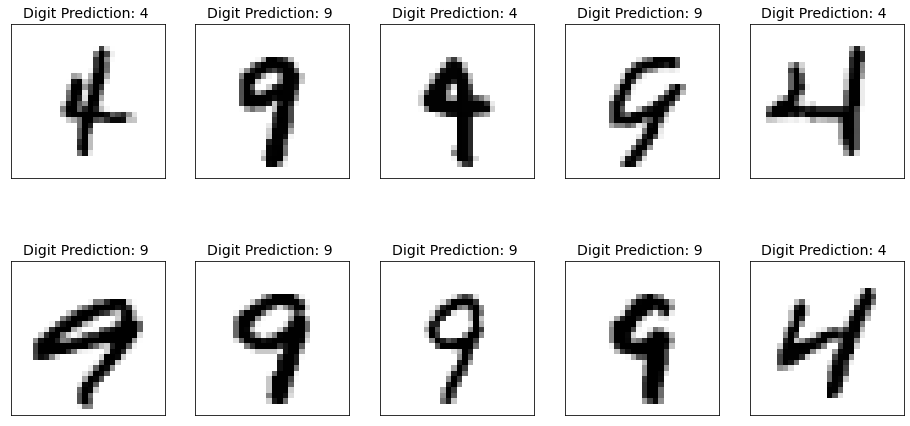

In [16]:
# Prediction Results
np.random.seed(2020)
idxs = np.random.choice(len(Y_test), 10, replace=False)
label_to_class = {0: '4', 1: '9'}

plt.figure(figsize=(16, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    predict, _ = forward(X_test_bar, Y_test, w_bar)
    pred_label = (predict[idx] >= 0.5).astype(np.int)
    plt.imshow(X_test[idx], cmap='gray_r')
    plt.title('Digit Prediction: {} '.format(label_to_class[pred_label]), fontsize=14)
    plt.xticks([]); plt.yticks([])

### Step 3 Apply to the CIFAR10 dataset

#### step 3-1 Implement training code combining all the methods above

## **TODO**: Fill in the blank and **attach the result** in your report.

In [17]:
X_train_flatten, Y_train, X_test_flatten, Y_test = cifar10_subset([0, 1])

X_train_flatten = X_train_flatten.reshape(2 * 5000, -1)
X_test_flatten = X_test_flatten.reshape(2 * 1000, -1)
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)
print(str(X_train.shape))
print(str(Y_train.shape))
print(str(X_test.shape))
print(str(Y_test.shape))

X_train_std = X_train_flatten / 255.
X_test_std = X_test_flatten / 255.

(11791, 28, 28)
(10000,)
(1991, 28, 28)
(2000,)


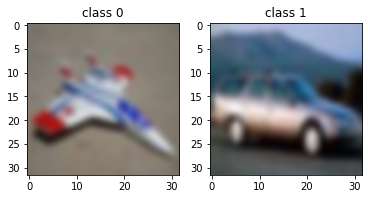

In [18]:
#show image
import matplotlib.pyplot as plt

image1 = X_train_flatten[1].reshape(3,32,32).transpose([1,2,0])
image2 = X_train_flatten[5000].reshape(3,32,32).transpose([1,2,0])
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(image1,  interpolation="bicubic")
plt.title('class {}'.format(Y_train[0].astype(np.int)))
plt.subplot(122)
plt.imshow(image2,  interpolation="bicubic")
plt.title('class {}'.format(Y_train[5000].astype(np.int)))
plt.show()

In [19]:
# hyperparameter
num_of_iteration = 5000
learning_rate = 0.1

# fix random seed for reproducibility
np.random.seed(100)

# Model initialization and add bias unit
X_train_bar, w_bar = initialize_params(X_train_std, False)

if w_bar.ndim != Y_train.ndim:  # if w is implemented as a column vector
    w_bar = w_bar.squeeze()
    
it = tqdm(range(num_of_iteration))
for i in it:
    
    ######################## Blank ########################
    predict, loss = forward(X_train_bar, Y_train, w_bar)    # compute prediction, loss using forward function
    train_acc = accuracy(predict, Y_train)                  # compute train accuracy 
    grad_w = backward(X_train_bar, Y_train, predict)        # compute gradient using backward function
    w_bar -= learning_rate * grad_w                         # weight update using gradient descent
    #######################################################
    
    if i % 100 == 0:
        it.set_postfix(accuracy='{:.2f}'.format(train_acc),
                      loss='{:.4f}'.format(loss))
    
# compute the train & test accuracy
predict, _ = forward(X_train_bar, Y_train, w_bar)
train_acc = accuracy(predict, Y_train)
print('train accuracy: {:.2f}'.format(train_acc))

unit_ones = np.ones((len(X_test_std), 1))
X_test_bar = np.concatenate((X_test_std, unit_ones), axis=1)  # add bias unit for test dataset

predict, _ = forward(X_test_bar, Y_test, w_bar)
test_acc = accuracy(predict, Y_test)
print('test accuracy: {:.2f}'.format(test_acc))

100%|██████████| 5000/5000 [09:30<00:00,  8.76it/s, accuracy=74.10, loss=1.6516]


train accuracy: 74.22
test accuracy: 73.80


### Step 4 Implement Logistic Regression with L2 Regularization

## **TODO** : Fill in the blank with the code by referring to the following formulas below for all the **steps 4-1 ~ 4-2.** You should write your own **description of your source code** in the report.

#### step 4-1. Implement forward propagation with regularization term

__x__: Input data of size (sample_size, feature_size); $(x_1, y_1)$, $(x_2, y_2)$, ... $(x_n, y_n)$.

__y__: target (labels)

__w__: model weights

**lambda_**: regularization parameter

__predict__: Prediction for each data point $x_i$ : $h(w^Tx_i)=\dfrac{1}{1+e^{-w^T x_i}}$ 

__loss__: $J(w)=\frac{1}{n}\sum_{i=1}^n[-y_i\text{log}\{h(w^Tx_i)\} - (1-y_i)\text{log}\{1-h(w^Tx_i)\}] + \frac{\lambda}{2n}\Vert w\Vert^2_2$

where $n$ is number of samples and $y$ is target.

**Hint**: use ```numpy.linalg.norm``` method

In [23]:
from numpy.linalg import norm

def forward_with_regularization(x, y, w, lambda_, eps=1e-8):
    ######################## Blank ########################
    linear = np.matmul(w.T, x.T)
    predict = sigmoid(linear).T
    n = x.shape[0]
    loss = ((-1/n)*(np.matmul(y, np.log(predict+eps)) + np.matmul((1-y), np.log(1-predict+eps)))) + (lambda_/(2*n))*(norm(w)**2)
    #######################################################
    return predict, loss

#### step 4-2. Implement backward propagation

__Hint:__ Refer to the following derivation.

$$
\begin{aligned}
\frac{\partial J(\boldsymbol{w})}{\partial \boldsymbol{w}} &=-\frac{1}{n} \sum_{i=1}^{n}\left[y_{i}\left(1-h\left(\boldsymbol{w}^{T} \boldsymbol{x}_{i}\right)\right)-\left(1-y_{i}\right) h\left(\boldsymbol{w}^{T} \boldsymbol{x}_{i}\right)\right] \boldsymbol{x}_{i} + \frac{\lambda}{n}w \\
&=\frac{1}{n} \sum_{i=1}^{n}\left[h\left(\boldsymbol{w}^{T} \boldsymbol{x}_{i}\right)-y_{i}\right] \boldsymbol{x}_{i} + \frac{\lambda}{n}w\\
&= \frac{1}{n} (\hat{Y}-Y)X + \frac{\lambda}{n}w
\end{aligned}
$$

In [24]:
def backward_with_regularization(x, y, w, predict, lambda_):
    ######################## Blank ########################
    n = x.shape[0]
    grad_w = 1/n * ((np.matmul((predict.T - y), x)) + (lambda_* w))
    #######################################################
    return grad_w

#### step 4-3. Training Regularized logistic regression with different $\lambda$ (Apply to the MNIST dataset)



Load the MNIST dataset again

In [25]:
# Dataset Load
X_train = np.load('mnist_49/X_train.npy')
X_test = np.load('mnist_49/X_test.npy')
Y_train = np.load('mnist_49/Y_train.npy')
Y_test = np.load('mnist_49/Y_test.npy')

# Reshape the training and test examples
# Data from Part 1 - Step 1
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

X_train_std = X_train_flatten / 255.
X_test_std = X_test_flatten / 255.

## **TODO**: Fill in the blank and **attach the results and the figure** in your report.

  0%|          | 0/5000 [00:00<?, ?it/s, accuracy=51.05, loss=5.9100]

train accuracy: 97.32
test accuracy: 96.38


  0%|          | 0/5000 [00:00<?, ?it/s, accuracy=43.19, loss=2.5830]

train accuracy: 97.38
test accuracy: 96.94


  0%|          | 0/5000 [00:00<?, ?it/s, accuracy=59.98, loss=2.2368]

train accuracy: 97.46
test accuracy: 96.94


  0%|          | 0/5000 [00:00<?, ?it/s, accuracy=49.71, loss=2.8139]

train accuracy: 97.35
test accuracy: 96.99


  0%|          | 1/5000 [00:00<08:20,  9.98it/s, accuracy=51.79, loss=4.1822]

train accuracy: 97.39
test accuracy: 96.99


  0%|          | 0/5000 [00:00<?, ?it/s, accuracy=40.22, loss=2.8347]

train accuracy: 97.29
test accuracy: 97.19


  0%|          | 0/5000 [00:00<?, ?it/s, accuracy=52.21, loss=3.1562]

train accuracy: 97.40
test accuracy: 97.24


  0%|          | 0/5000 [00:00<?, ?it/s, accuracy=42.92, loss=4.2759]

train accuracy: 97.30
test accuracy: 97.14


  0%|          | 0/5000 [00:00<?, ?it/s, accuracy=51.78, loss=3.7943]

train accuracy: 97.24
test accuracy: 97.09


100%|██████████| 5000/5000 [07:10<00:00, 11.62it/s, accuracy=97.08, loss=0.1168]


train accuracy: 97.08
test accuracy: 96.99


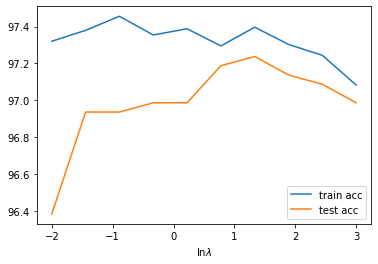

In [26]:
# hyperparameter
num_of_iteration = 5000
learning_rate = 0.5
lin_lambdas = np.linspace(-2, 3, 10)  
lambdas = np.power(np.e, lin_lambdas)  # Regularization parameter (lambda) = e^-2 ~ e^3

# fix random seed for reproducibility
np.random.seed(100)

# add bias unit for test dataset
unit_ones = np.ones((len(X_test_std), 1))
X_test_bar = np.concatenate((X_test_std, unit_ones), axis=1)  

train_accuracies = []
test_accuracies = []
    
for lambda_ in lambdas:

    # Model initialization and add bias unit
    X_train_bar, w_bar = initialize_params(X_train_std, False)

    if w_bar.ndim != Y_train.ndim:  # if w is implemented as a column vector
        w_bar = w_bar.squeeze()
    
    it = tqdm(range(num_of_iteration))
    for i in it:
        
        ######################## Blank ########################
        predict, loss = forward_with_regularization(X_train_bar, Y_train, w_bar, lambda_)    # compute prediction, loss using forward function
        train_acc = accuracy(predict, Y_train)                                               # compute train accuracy 
        grad_w = backward_with_regularization(X_train_bar, Y_train, w_bar, predict, lambda_) # compute gradient using backward function
        w_bar -= learning_rate * grad_w.T                                                    # weight update using gradient descent
        #######################################################

        if i % 100 == 0:
            it.set_postfix(accuracy='{:.2f}'.format(train_acc), 
                           loss='{:.4f}'.format(loss))
    
    # compute the train & test accuracy
    predict, _ = forward_with_regularization(X_train_bar, Y_train, w_bar, lambda_)
    train_acc = accuracy(predict, Y_train)
    print('train accuracy: {:.2f}'.format(train_acc))
    train_accuracies.append(train_acc)

    predict, _ = forward_with_regularization(X_test_bar, Y_test, w_bar, lambda_)
    test_acc = accuracy(predict, Y_test)
    print('test accuracy: {:.2f}'.format(test_acc))
    test_accuracies.append(test_acc)
    
plt.plot(lin_lambdas, train_accuracies, label='train acc')
plt.plot(lin_lambdas, test_accuracies, label='test acc')
plt.xlabel('$\ln\lambda$')
plt.legend()
plt.show()

## **Part3.** Hyperparameter Optimization

* Understand and Implement various classifiers learned in class.
* Find a best combination of hyperparameters for each classifier.

### Step1. sample training data

In [27]:
train_images_cl, train_labels_cl, test_images_cl, test_labels_cl = cifar10_subset([0,2,7])
# train_images_cl.shape : (3,5000,3072)
# train_labels_cl.shape : (3,5000)
# test_images_cl.shape : (3,1000,3072)
# train_labels_cl.shape : (3,1000)

* Set the train, test sample size to be 1500, 500 respectively.

In [28]:
classes = np.unique(train_labels_cl)

Len1, Len2 = 1500, 500 # sample size of Train data and Test data, respectively.
for i, cls in enumerate(classes):
    if i == 0:
        X_train, Y_train = train_images_cl[i, :Len1], train_labels_cl[i,:Len1]
        X_test, Y_test = test_images_cl[i, :Len2], test_labels_cl[i, :Len2]
    else:
        X_train, Y_train = np.append(X_train, train_images_cl[i, :Len1],0), np.append(Y_train, train_labels_cl[i, :Len1],0)
        X_test, Y_test = np.append(X_test, test_images_cl[i, :Len2],0), np.append(Y_test, test_labels_cl[i, :Len2],0)

print(str(X_train.shape))
print(str(Y_train.shape))
print(str(X_test.shape))
print(str(Y_test.shape))

(4500, 3072)
(4500,)
(1500, 3072)
(1500,)


### Step2. Optimize hyperparameters for Logistic Regression Classifier

## **TODO**: Find best performing combination of **learning rate** and **regularization parameter**. Attach the **best combination** and corresponding **result** in your report.

* You should use function of scikit-learn **(sklearn.linear_model.SGDClassifier)**.
* You should set option **loss** to **log** to perform logistic regression.
* You should set option **alpha** to control regularization parameter.
* You should set option **eta0** to control learning rate.
* See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn-linear-model-sgdclassifier for more information

**Grids to be searched are provided as follows**:

```Learning rate: [1e-1, 1e-2, 1e-3]```

```Regularization parameter: [1e-3, 1e-4, 1e-5]```

In [30]:
from sklearn.linear_model import SGDClassifier
np.random.seed(0)

######################## Blank ########################
param_grid = dict(alpha=[1e-3, 1e-4, 1e-5], learning_rate=["constant"], eta0=[1e-1, 1e-2, 1e-3]) 
from sklearn.model_selection import GridSearchCV
sgd = SGDClassifier(loss = "log") 
grid = GridSearchCV(estimator=sgd, param_grid=param_grid, cv=5, n_jobs=-1, verbose=10) 
grid_result = grid.fit(X_train, Y_train)
pred = grid_result.predict(X_test)
acc = accuracy(pred, Y_test)
eta0 = grid_result.best_params_['eta0']
alpha = grid_result.best_params_['alpha']
#######################################################
print(f'eta0 is {eta0}, alpha is {alpha}, Acc = {acc}%')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   55.7s finished


eta0 is 0.01, alpha is 0.001, Acc = 25.933333333333337%


### Step3. Optimize hyperparameters for SVM Classifier

## **TODO**: Find best performing combination of **kernel** and **regularization parameter**. Attach the **best combination** and corresponding **result** in your report.

* You should use function of scikit-learn **(sklearn.svc.SVC)**.
* You should set option **kernel** to control the type of kernel.
* You should set option **C** to control regularization parameter.
* See https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html for more information

**Grids to be searched are provided as follows**:

```Kernel: ['linear','rbf','poly']```

```Regularization parameter (C): [0.1, 1, 10, 100]```

In [ ]:
from sklearn.svm import SVC
np.random.seed(0) 

######################## Blank ########################
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly']}
from sklearn.model_selection import GridSearchCV
svc = SVC()
grid = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=10)
grid_result = grid.fit(X_train,Y_train)
pred = grid_result.predict(X_test)
acc = accuracy(pred, Y_test)
#print('Best Score: ', grid_result.best_score_) 
#print('Best Params: ', grid_result.best_params_)
C = grid_result.best_params_['C']
kernel = grid_result.best_params_['kernel']
#######################################################
print(f'kernel is {kernel}, C is {C}, Acc = {acc}%')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 40.6min finished


kernel is rbf, C is 10, Acc = 25.733333333333334%


## **Part4.** PCA

* Understand and Implement PCA in Iris dataset.
* Using numpy to make PCA and compare your PCA to PCA which made by using scikit-learn package


### Step 1. Load Iris dataset


In [33]:
import pandas as pd
from sklearn import datasets

iris = datasets.load_iris()
iris_x = iris.data
iris_y = iris.target
print(str(iris_x.shape))
print(str(iris_y.shape))

#visualization
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                  columns= iris['feature_names'] + ['target'])
display(df.head())

(150, 4)
(150,)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Step 2. Using numpy to implement PCA (with Iris dataset)

## **TODO** : Fill in the blank with the code by referring to the following formulas below for all the **steps 2-1 ~ 2-4.** You should write your own **description of your source code** in the report.

#### step 2-1 : Standardize the dataset

$$ z = \frac{(x- u)}{s} ~~~~~~\text{(feature-wise operation)}$$ 

$u$ is the sample mean and $s$ is standard deviation of the training samples

__Hint__: Compute ```mean``` and ```std``` across ```axis=0``` (feature-wise).

**Note**: Use ```iris_x``` for $x$.

In [34]:
#step1: Standardization
######################## Blank ########################
mean = np.mean(iris_x, axis=0)
A = iris_x - (mean * np.ones((150, 1)))
std = np.std(iris_x, axis=0)
z = A / (std * np.ones((150, 1)))
#######################################################
print("The mean of z:", z.mean(0))

The mean of z: [-1.69031455e-15 -1.84297022e-15 -1.69864123e-15 -1.40924309e-15]


#### step 2-2 : Find the covariance matrix

__Hint:__ Refer to the following formula. And use ```np.cov```method.

$$ \operatorname{cov}(\mathbf{X})=\frac{1}{n-1} \mathbf{X}^{T} \mathbf{X} $$

$n$ is the number of training samples

**Note**: Use standardized dataset ```z``` for $\mathbf{X}$ in formula above.

In [35]:
#step2: Find the covariance matrix
######################## Blank ########################
#co = np.matmul(z.T, z) / 149
#print(co)
covar_matrix = np.cov(z.T)
#######################################################
print("The shape of covariance matrix: ",covar_matrix.shape)

The shape of covariance matrix:  (4, 4)


#### step 2-3 : Find the eigenvalues and eigenvectors of the covariance matrix

The principal components can be determined via eigen decomposition of the covariance matrix $\mathbf{C}$. \
$$\mathbf{C}=\mathbf{W} \mathbf{\Lambda} \mathbf{W}^{T}$$

$\mathbf{C}$ is covariance matrix,  $\mathbf{W}$ is matrix of eigenvectors, $\mathbf{\Lambda}$ is a diagonal matrix of m eigenvalues.\
The geometrical meaning of eigen decomposition is to find a new coordinate system of the eigenvectors for $\mathbf{C}$.

__Hint__: Use ```np.linalg.eig``` method

**Note**: Use ```covar_matrix``` for covariance matrix $\mathbf{C}$.

In [36]:
#step3 : Find the eigenvalues and eigenvectors of the covariance matrix
######################## Blank ########################
eig_vals, eig_vecs = np.linalg.eig(covar_matrix)
#######################################################

#### step 2-4 : Get eigenvectors of 2 biggest eigenvalues and form the projection matrix 

The first k principal components explain the most variance any k variables can explain. \
To express our dataset in 2 dimensions, find eigenvectors of 2 biggest eigenvalues. \
Then project the data points onto the first 2 PCs as the representation of the data:

$$\mathbf{X}_{k}=\mathbf{X} \mathbf{W}_{k}$$

**Note**: Use ```eig_vals``` and ```eig_vecs``` for eigen values and eigen vectors respectively.




In [53]:
#step4 : Get first 2 eigenvectors of 2 biggest eigenvalues and form the projection matrix
######################## Blank ########################
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])
print("All Eigen Values along with Eigen Vectors")
print(eig_pairs)
w_matrix = np.hstack((eig_pairs[0][1].reshape(4,1),
                      eig_pairs[1][1].reshape(4,1)))
projected_X = np.dot(iris_x, w_matrix)
#######################################################
print("The shape of projected data: ", projected_X.shape)

Eigenvalues in descending order:
2.938085050199995
0.9201649041624864
0.1477418210449475
0.020853862176462696
All Eigen Values along with Eigen Vectors
[(2.938085050199995, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654])), (0.9201649041624864, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199])), (0.1477418210449475, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274])), (0.020853862176462696, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))]
The shape of projected data:  (150, 2)


#### step 2-5 : Get variance ratio
The fraction of variance explained by a principal component is the ratio between the variance of that principal component and the total variance.

## **TODO**: Run all the provided code below and **attach the results** in your report.

In [51]:
#Step5 : get variance ratio
variance_ratio = eig_vals[:2]/eig_vals.sum()
print(variance_ratio)

[0.72962445 0.22850762]


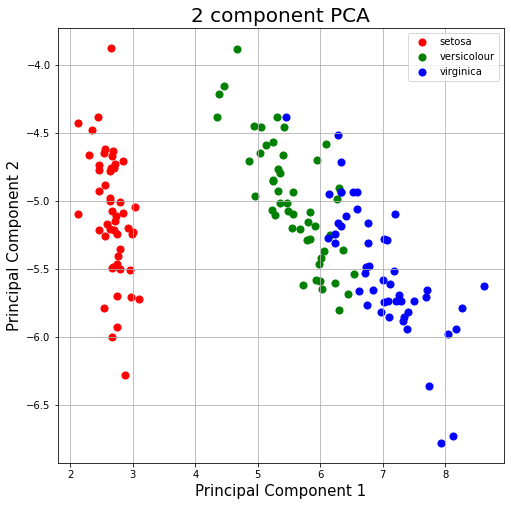

In [52]:
#Visualization
principalDf = pd.DataFrame(data=projected_X, columns=['principal component 1','principal component 2'])
principalDf['target'] = iris_y

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = {'setosa': 0, 'versicolour' : 1, 'virginica' : 2}
colors = ['r', 'g', 'b']
for target, color in zip(targets.values(),colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets.keys())
ax.grid()

### Step 3. Using sklearn PCA package  (with Iris dataset)

## **TODO**: Run all the provided code below and **compare the results** with numpy implemented PCA in your report. 

#### step 3-1 : Standardization using ```sklearn.preprocessing.StandardScalar``` module



In [47]:
from sklearn.preprocessing import StandardScaler
#Step1. Standardization using StandardScaler
z = StandardScaler().fit_transform(iris_x)
print("The mean of z:", z.mean(axis=0))

The mean of z: [-1.69031455e-15 -1.84297022e-15 -1.69864123e-15 -1.40924309e-15]


#### step 3-2 : PCA projection to 2 components using ```sklearn.decomposition.PCA``` module

In [45]:
from sklearn.decomposition import PCA
#Step2. PCA projection to 2 components
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(z)

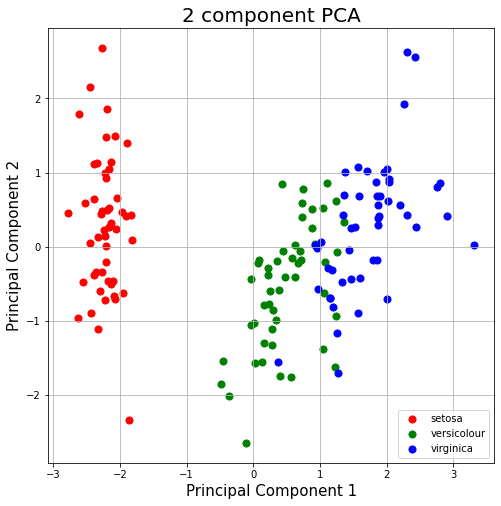

In [42]:
#Visualization
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1','principal component 2'])
principalDf['target'] = iris_y

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = {'setosa': 0, 'versicolour' : 1, 'virginica' : 2}
colors = ['r', 'g', 'b']
for target, color in zip(targets.values(),colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets.keys())
ax.grid()

In [43]:
#Step3 : Get eigenvlaue and variance ratio of covariance matrix

print('eigen_value :', pca.explained_variance_)
print('explained variance ratio:', pca.explained_variance_ratio_)

eigen_value : [2.93808505 0.9201649 ]
explained variance ratio: [0.72962445 0.22850762]
